In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Lecture 25:

- Learn how to use satellite imagery to understand land usage.
- Learn how to use patches in matplotlib.
- Learn about using the **scikit-learn** python package to classify data.

### Using Landsat Satellite Data

The landsat series of satellites provide satellite imagery for the entire Earth's surface. They are frequently used to study land management. Landsat data vary depending on which satellite is being used. Today we will be using data from Landsat Series 7. Landsat satellites record the brightness of reflected light in multiple different wavelength 'bands'. This means that the satellite gets a separate value for different colors of light.

| Band       | Wavelength (micrometers)| Color          | Resolution (m) |
| -----------|-------------------------| ---------------|----------------|
| 1          | 0.45-0.52               | Blue           | 30             |
| 2          | 0.52-0.60               | Green          | 30             |
| 3          | 0.63-0.69               | Red            | 30             |
| 4          | 0.77-0.90               | Near Infrared  | 30             |
| 5          | 1.55-1.75               | Infrared 1     | 30             |
| 6          | 10.40-12.50             | Thermal        | 60             |
| 7          | 2.09-2.35               | Infrared 2     | 30             |
| 8          | 0.52-0.90               | Panchromatic   | 15             |



For this lecture, we're going to look at putting labels on the landsat data for the area around the town of Bellingham, Washington. The data come from the USGS Global Land Survey dataset for this region from Sep 25th 2009 https://earthexplorer.usgs.gov/. 

In the datasets folder, we have a set of TIF images for each of the bands in the landsat dataset. Each image contains the level of  brightness in the given color band for each picture. To get an understanding, let's read in one of our TIF files, and plot the data using **plt.imread( )** and **plt.imshow( )**.

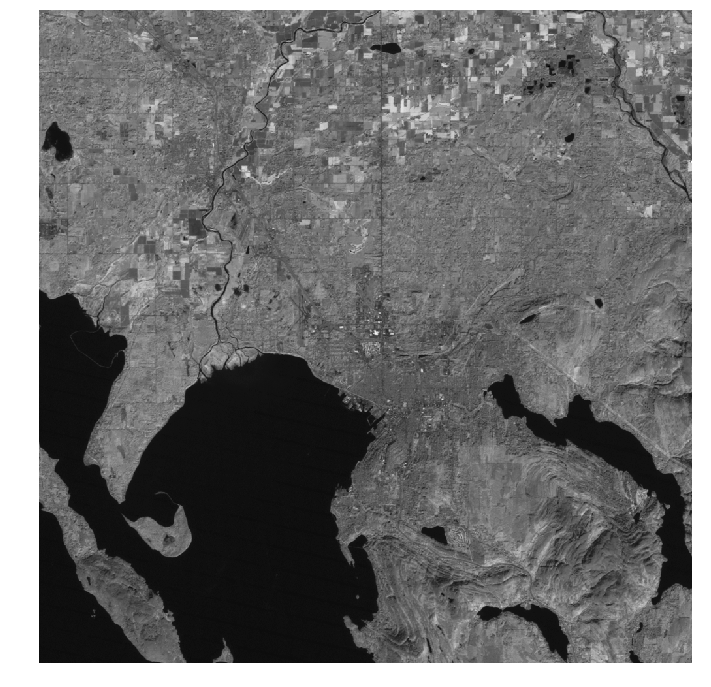

In [2]:
B4=plt.imread('Datasets/Landsat_Data/B4.TIF') #Read in the TIF file #filter the TIF file data for the region of interest
plt.figure(figsize=(16,12)) #make  a big figure object
plt.imshow(B4,cmap='Greys_r') #Plot the data for band 4 as a greyscale image.
plt.axis('Off'); #Turn off the plotting axes with tick marks, etc.

This gives us the brightness seen just in the 'Near Infrared' band. We can definitely see the land here and ocean here, but it's hard to tell what's going on in the landscape and we don't just want our satellite imagery in black and white - we want color!. 

For simplicity's sake, let's ignore bands 6 and 8 which have different resolutions and just read in the images for the other 5 color bands.

In [3]:
B1=plt.imread('Datasets/Landsat_Data/B1.TIF')
B2=plt.imread('Datasets/Landsat_Data/B2.TIF')
B3=plt.imread('Datasets/Landsat_Data/B3.TIF')
B5=plt.imread('Datasets/Landsat_data/B5.TIF')
B7=plt.imread('Datasets/Landsat_data/B7.TIF')

Let's combine some of these bands into a False color image. We can use different combinations of the bands by making a 1000x1000x3 array and passing it to **plt.imshow( )**. Each of the 1000x1000 elements in the array represents a pixel, within that we have 3 values for the amount of Red, Green or Blue. 

For our False color image, we're going to use band 5 (infrared) for "Red", band 4 (near infrared) for "Green" and band 3 (red) for "Blue". We will use these bands as it looks a bit nicer than a true color image (for which we would use bands 3, 2 and 1 - but you could try it both ways!).

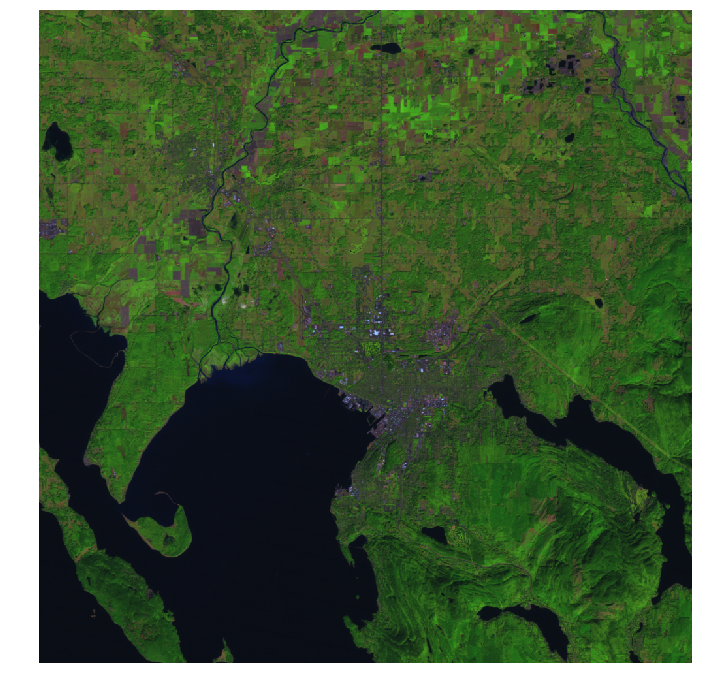

In [4]:
RGB=np.array([B5.T,B4.T,B3.T]).T #Make an RGB image from bands 5, 4 and 3
plt.figure(figsize=(16,12)) #Plot a big figure
plt.imshow(RGB) #Plot the RGB array
plt.axis('Off');

OK! Now we're getting somewhere. We can clearly see the main city close to the center of the image, farmland to the North and forested areas to the South. What if we wanted to know what percentage of the area in this image is forested? **scikit-learn** can help!

### Classification
This kind of problem is known as _classification_, a type of supervised learning. To classify data, you gather a _training_ dataset where you already label part of your data, then you _train_ your algorithm on this dataset and have it assign labels to the rest of your data. You've all probably done some of this, whenever you log in to a website and they make you identify a car in the image, you are helping to train a program to see cars. Let's see how we might practically do this with our Landsat data.

### Making our training dataset and using patches to represent it.

An easy way of making our 'training' dataset would be to put a square on the map that contains only one type of terrain (Farmland, Water, City/Buildings and Forest). Let's display these on the graph using a handy feature of **matplotlib** called **patches** which can be used to draw shapes on a plot. To draw our squares, we're going to import the object **Rectangle( )** from **matplotlib.patches**. **Rectangle** takes arguments for the top left corner, width and height of the rectangle, and the face and edgecolors. We're going to make all our squares 70x70 (4900 training pixels) and label them with **plt.text( )**. Let's add our patches and text to our RGB plot above.

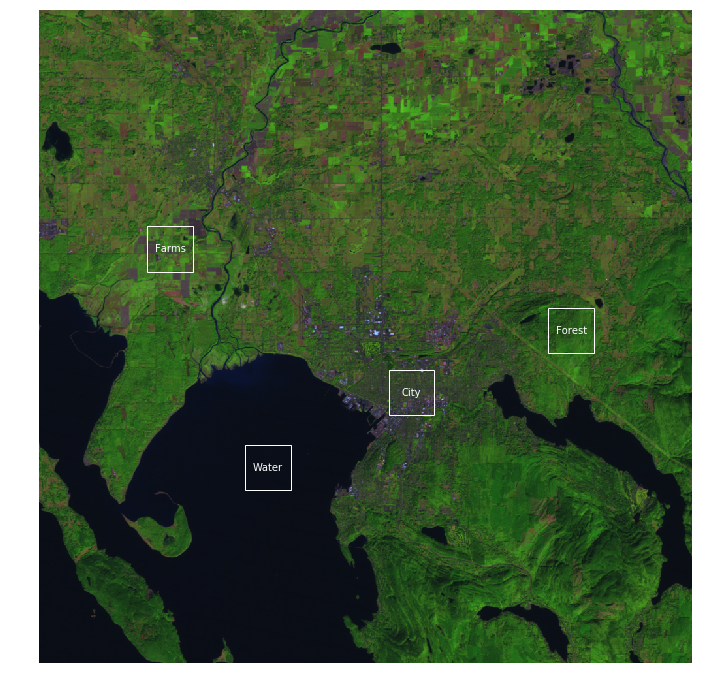

In [5]:
from matplotlib.patches import Rectangle 

fig,ax=plt.subplots(figsize=(16,12)) #Make a figure and axis object to plot patches onto

plt.imshow(RGB) #Add the base RGB image

#Add the patches

#Add a 70x70 square with top left corner 535,550. Set the square to have no fill (so we can see through it)
#Set the edge of the square to be white
ax.add_patch(Rectangle([535,550],70,70,facecolor='None',edgecolor='w')) 

#Plot text in the middle of the square
plt.text(570,585,'City',color='w',horizontalalignment='center',verticalalignment='center')

#Add our other squares
ax.add_patch(Rectangle([165,330],70,70,facecolor='None',edgecolor='w'))
plt.text(200,365,'Farms',color='w',horizontalalignment='center',verticalalignment='center')
ax.add_patch(Rectangle([315,665],70,70,facecolor='None',edgecolor='w'))
plt.text(350,700,'Water',color='w',horizontalalignment='center',verticalalignment='center')
ax.add_patch(Rectangle([780,455],70,70,facecolor='None',edgecolor='w'))
plt.text(815,490,'Forest',color='w',horizontalalignment='center',verticalalignment='center')

#Remove the axis
plt.axis('Off');

### Converting our data into the right format
Let's grab the data from inside these squares and turn it into a format that **scikit-learn** can understand. 

In [6]:
#Create empty lists for each of our types of terrain
farms=[]
water=[]
city=[]
forest=[]

#populate the empty lists
for band in [B1,B2,B3,B4,B5,B7]:
    farms.append(band[330:400,165:235].flatten())
    water.append(band[665:735,315:385].flatten())
    city.append(band[550:620,535:605].flatten())
    forest.append(band[455:525,780:850].flatten())
    
#Turn our lists into arrays and transpose them to make them readable by scikit-learn
farms=np.array(farms).transpose()
water=np.array(water).transpose()
city=np.array(city).transpose()
forest=np.array(forest).transpose()


#For the training dataset, make an empty array with the right shape to append each of our terrain arrays to
training_data=np.empty((0,6))

#Append the terrain arrays to the empty array. Note that the axis=0 makes sure the array is 2d.
for item in [farms,city,water,forest]:
    training_data=np.append(training_data,item,axis=0)

We also need to make an array of labels that is the same length as the array of training data. These tell **scikit-learn** what type of terrain each data point is associated with.  For this we can use the function **np.full( )** which returns a new array of a given shape and type filled with a **fill\_value**. 

In [7]:
#Make an array of labels for each of the terrain datasets
farms_labels=np.full(len(farms),'farms')
city_labels=np.full(len(city),'city')
water_labels=np.full(len(water),'water')
forest_labels=np.full(len(forest),'forest')


training_labels=np.array([])
for item in [farms_labels,city_labels,water_labels,forest_labels]:
    training_labels=np.append(training_labels,item)

### Classifying the satellite image
Now we can classify our data in **scikit-learn**. Although there are lots of classificiation methods in the package, one of the most simple is **KNeighborsClassifier**. This works by finding the pixels in the training dataset that are closest to the pixel being analyzed - aka the 'nearest neighbors'.

In [8]:
from sklearn.neighbors import KNeighborsClassifier
#Make a nearest neighbors classifier object
nneighbors=KNeighborsClassifier()
#Fit the classifier using the training dataset
fit=nneighbors.fit(training_data,training_labels)

Now let's grab the whole dataset and turn it into an array that **scikit_learn** can understand. We can then predict the labels for this. Note that this may take some time to do the prediction for a million pixels!

In [9]:
#Make image data readable by scikit-learn
full_image_data=np.array([B1.flatten(),B2.flatten(),B3.flatten(),\
                 B4.flatten(),B5.flatten(),B7.flatten()]).transpose()

#Work out labels for the whole image
prediction=fit.predict(full_image_data)

Now we have to convert our list of labels back into a set of colors that **plt.imshow( )** can read. Let's use dark green for the forests, grey for the city/buildings, blue for the water and light green for the farmland. Instead of the words for colors, we can use the RGB color trick whereby each color can range from 0 to 255.  So... 'red' would be \[255,0,0\], 'green'  \[0,255,0\], and blue \[0,0,255\].  White is \[255,255,255\], black is \[0,0,0\] and grey is half-way in between: \[125,125,125\].  

In [10]:
prediction_RGB=[]
for i in prediction:
    if i=='farms':
        prediction_RGB.append([0,255,0]) # make farms green
    if i=='city':
        prediction_RGB.append([125,125,125]) # make cities grey
    if i=='water':
        prediction_RGB.append([0,0,255]) # make water blue
    if i=='forest':
        prediction_RGB.append([0,125,0]) # make forest dark green
prediction_RGB=np.array(prediction_RGB)

Finally, let's plot the final result and see how it did.

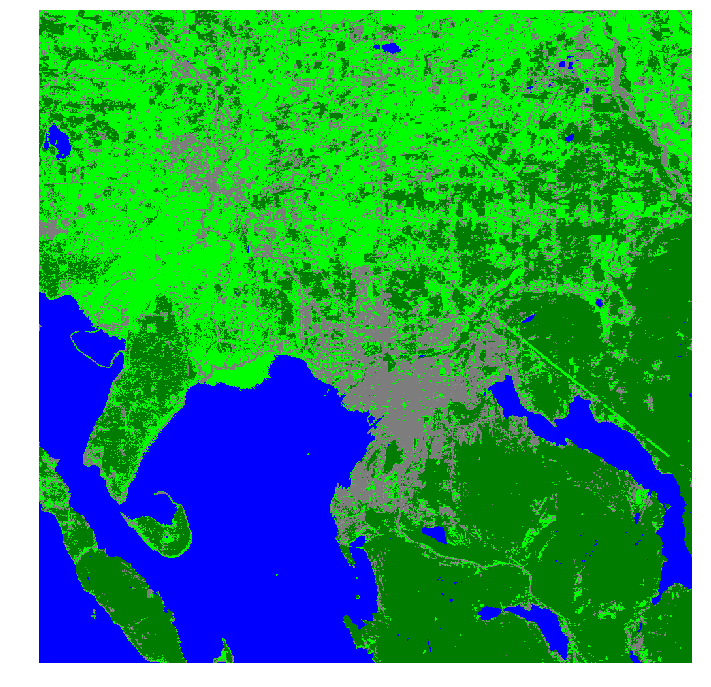

In [11]:
prediction_RGB=prediction_RGB.reshape(RGB.shape)
plt.figure(figsize=(16,12))
plt.imshow(prediction_RGB)
plt.axis('Off');

This looks like it identified everything very well. We have:
- Farmland in the North
- Forest in the South and West
- Built up areas where we would expect them to be
- Water in the right places

There are a couple of differences:
- Rivers are labelled as 'city'
- The delta at the mouth of the river is labelled as 'farms'

This is probably because river systems are shallower and have lots of sediment at the surface, making them  different from deep lakes, seas and oceans. Maybe we should have added an extra category for 'river', but we couldn't have done this with a square.

### What percentage of the image is forested?
We can now easily find the percentage of the area that is forested using array masking. Using our array **prediction** we can search for all of the pixels that are labelled as being forest.

In [12]:
n_forested_pixels=len(prediction[prediction=='forest']) #Find the number of forested pixels
n_pixels=len(prediction) #Find the total number of pixels
percent_forested=n_forested_pixels/n_pixels*100
print('The percentage of this area that is forested is %2.1f'%percent_forested+'%')

The percentage of this area that is forested is 33.1%


### Visualizing data using Principal Component Analysis.
As with a lot of machine learning approaches, it is a little 'black-boxy' in that is  difficult to understand exactly what our classifier is doing. Part of this is because there are a lot of datapoints, with 6 features each and our brains have difficulty 'seeing' in more than three dimensions. 

Here **scikit-learn** can help.  It offers one  option called  _Principal Component Analysis_. This is a type of analysis that finds a 2-D projection  of the data that shows the shape of the scatter the most effectively. It does this by grouping dimensions together into _principal components_.  The dimensions **scikit-learn** actually picks to clump together are generally very abstract and hard to relate to any 'real' measurement, but they show the scatter of the data quite nicely. In effect, instead of having to look at lots of different plots, **PCA**  allows us to look at just a single two dimensional plot to see the data. **PCA** is implemented into **scikit-learn** through the **decomposition** module. Let's fit a PCA to our training data and see where everything plots.

In [13]:
from sklearn.decomposition import PCA

pca=PCA(n_components=2) #We're going to use a PCA with 2 components because we want a 2d plot.
fit=pca.fit(training_data) #Fit the PCA to the training dataset

#Transform the datasets for different types of terrain to make them 'In PCA space'
farms_pca=fit.transform(farms)
city_pca=fit.transform(city)
water_pca=fit.transform(water)
forest_pca=fit.transform(forest)

Now let's make a scatterplot of the different things we can see in our satellite image. As it was fairly easy to classify them, we might expect them to form separate blobs on the scatter plot.

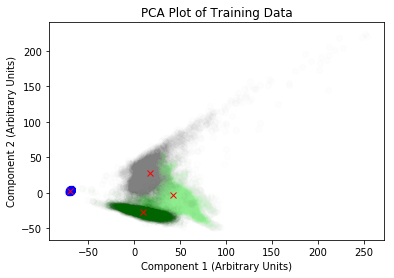

In [14]:
#Scatter our different types of land/water on the plot. 
#We use a low alpha (opacity) to show the density better with lots of points
plt.scatter(farms_pca[:,0],farms_pca[:,1],color='lightgreen',alpha=0.01,label='Farms')
plt.scatter(city_pca[:,0],city_pca[:,1],color='grey',alpha=0.01,label='City')
plt.scatter(water_pca[:,0],water_pca[:,1],color='blue',alpha=0.01,label='Water')
plt.scatter(forest_pca[:,0],forest_pca[:,1],color='darkgreen',alpha=0.01,label='Forest')

#Plot the means of the blobs as red xs
for item in [farms_pca,city_pca,water_pca,forest_pca]:
    plt.plot(np.mean(item[:,0]),np.mean(item[:,1]),'rx')
    
#Plot x and y labels and legend
plt.xlabel('Component 1 (Arbitrary Units)')
plt.ylabel('Component 2 (Arbitrary Units)')
plt.title('PCA Plot of Training Data');

From this, we can see that the forest, farmland, and city data have some significant overlap in our training dataset, but the water is very distinct. Classification is basically just trying to draw the boundaries between these blobs. 

### A final word of warning.

**scikit-learn** has a lot of different algorithms for regression, classification and clustering and it is important to choose the right one to get good results. The [**scikit-learn** website](https://scikit-learn.org) has lots of helpful documentation on how to do this. Importantly, all good machine learning models should be _validated_. This is a kind of check to tell you that the model is producing good results, or if one model is better than another. We did this graphically by looking at our satellite image, but **scikit-learn** provides packages that allow you to do this mathematically. If you don't have any way of evaluating how your model is doing, you don't know if any of the trends you are seeing are 'real' or not.